# UID Pipeline
This is a notebook to build and compute UID metrics at multiple context levels:
- Sentence-only (no prior context)
- Previous sentence(s) (local discourse)
- Document-level (full prior discourse)

## Setup

In [1]:
import math
import numpy as np
import pandas as pd
from pathlib import Path
from conllu import parse_incr
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

/Users/tzhang04/Desktop/active-passive-alternations/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download from GUM

In [2]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

GUM_URL = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-train.conllu"
GUM_PATH = DATA_DIR / "en_gum-ud-train.conllu"

# if not GUM_PATH.exists():
#     !curl -L -f -o {GUM_PATH} {GUM_URL} # IF ON WINDOWS USE WGET INSTEAD!!
    # specifically, do !wget -q -O {GUM_PATH} {GUM_URL}
    # for a quiet output

print("Loaded:", GUM_PATH)

Loaded: data/en_gum-ud-train.conllu


## Parse UD into documents

In [3]:
def sent_text(sent):
    toks = [t for t in sent if isinstance(t.get("id"), int)]
    return " ".join(t["form"] for t in toks)

def iter_ud_docs(path, limit_docs=None, limit_sents_per_doc=None):
    docs = []
    current_id = None
    current = []

    with open(path, "r", encoding="utf-8") as f:
        for sent in parse_incr(f):
            meta = sent.metadata
            if "newdoc id" in meta:
                if current_id is not None and current:
                    docs.append((current_id, current))
                    if limit_docs and len(docs) >= limit_docs:
                        return docs
                current_id = meta["newdoc id"]
                current = []

            text = meta.get("text") or sent_text(sent)
            if text:
                current.append(text)
                if limit_sents_per_doc and len(current) >= limit_sents_per_doc:
                    docs.append((current_id or "doc", current))
                    if limit_docs and len(docs) >= limit_docs:
                        return docs
                    current = []

        if current:
            docs.append((current_id or "doc", current))

    return docs

docs = iter_ud_docs(GUM_PATH, limit_docs=3, limit_sents_per_doc=8)
len(docs), [len(sents) for _, sents in docs]

(3, [8, 8, 8])

In [16]:
docs

[('GUM_academic_art',
  ['Aesthetic Appreciation and Spanish Art:',
   'Insights from Eye-Tracking',
   'Claire Bailey-Ross claire.bailey-ross@port.ac.uk University of Portsmouth, United Kingdom',
   'Andrew Beresford a.m.beresford@durham.ac.uk Durham University, United Kingdom',
   'Daniel Smith daniel.smith2@durham.ac.uk Durham University, United Kingdom',
   'Claire Warwick c.l.h.warwick@durham.ac.uk Durham University, United Kingdom',
   'How do people look at and experience art?',
   'Which elements of specific artworks do they focus on?']),
 ('GUM_academic_art',
  ['Do museum labels have an impact on how people look at artworks?',
   'The viewing experience of art is a complex one, involving issues of perception, attention, memory, decision-making, affect, and emotion.',
   'Thus, the time it takes and the ways of visually exploring an artwork can inform about its relevance, interestingness, and even its aesthetic appeal.',
   'This paper describes a collaborative pilot project f

In [4]:
print(docs[0])

('GUM_academic_art', ['Aesthetic Appreciation and Spanish Art:', 'Insights from Eye-Tracking', 'Claire Bailey-Ross claire.bailey-ross@port.ac.uk University of Portsmouth, United Kingdom', 'Andrew Beresford a.m.beresford@durham.ac.uk Durham University, United Kingdom', 'Daniel Smith daniel.smith2@durham.ac.uk Durham University, United Kingdom', 'Claire Warwick c.l.h.warwick@durham.ac.uk Durham University, United Kingdom', 'How do people look at and experience art?', 'Which elements of specific artworks do they focus on?'])


## Load LM
note - using distilgpt for fast prototyping, use gpt-2 for final

In [9]:
MODEL_NAME = "distilgpt2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

if tokenizer.bos_token_id is None:
    tokenizer.bos_token = tokenizer.eos_token

model.eval()

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps") # metal for mac
else:
    device = torch.device("cpu")
    
model.to(device)
print("device:", device)

Loading weights: 100%|██████████| 76/76 [00:00<00:00, 2664.32it/s, Materializing param=transformer.wte.weight]            
GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


device: mps


## Context Building

In [10]:
def build_context(sents, idx, mode, k=None, max_tokens=None):
    # mode: none, prev, doc
    if mode == "none" or idx == 0:
        return ""

    if mode == "prev":
        k = k or 1
        start = max(0, idx - k)
        return " ".join(sents[start:idx])

    if mode == "doc":
        return " ".join(sents[:idx])

    return ""


## Surprisal Calculations

token level surprisal for the current sentence only

In [11]:
def compute_surprisal(sentence, context, tokenizer, model, max_len=None):
    context_ids = tokenizer.encode(context, add_special_tokens=False)
    sent_ids = tokenizer.encode(sentence, add_special_tokens=False)

    # Add BOS to allow a probability for the first token
    context_ids = [tokenizer.bos_token_id] + context_ids

    max_len = max_len or getattr(tokenizer, "model_max_length", 1024)
    total_len = len(context_ids) + len(sent_ids)
    if total_len > max_len:
        overflow = total_len - max_len
        if overflow < len(context_ids):
            context_ids = context_ids[overflow:]
        else:
            sent_ids = sent_ids[-max_len + 1:]
            context_ids = [tokenizer.bos_token_id]

    input_ids = torch.tensor([context_ids + sent_ids], device=device)

    with torch.no_grad():
        logits = model(input_ids).logits
        log_probs = torch.log_softmax(logits, dim=-1)

    start = len(context_ids)
    surprisals = []
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    for i in range(start, input_ids.size(1)):
        token_id = input_ids[0, i]
        lp = log_probs[0, i - 1, token_id]
        surprisal = (-lp / math.log(2)).item()
        surprisals.append(surprisal)

    sent_tokens = tokens[start:]
    return sent_tokens, surprisals

## Really basic UID metrics

In [12]:
def uid_metrics(surprisals):
    if not surprisals:
        return {}
    arr = np.array(surprisals)
    mean = arr.mean()
    std = arr.std()
    mad = np.mean(np.abs(arr - mean))
    rng = arr.max() - arr.min()

    x = np.arange(len(arr))
    slope = np.polyfit(x, arr, 1)[0] if len(arr) > 1 else 0.0

    return {
        "uid_mean": mean,
        "uid_std": std,
        "uid_mad": mad,
        "uid_range": rng,
        "uid_cv": std / mean if mean > 0 else 0.0,
        "uid_slope": slope,
        "uid_len": len(arr),
    }

## Full pipeline

In [13]:
context_levels = [
    {"name": "sentence", "mode": "none"},
    {"name": "prev1", "mode": "prev", "k": 1},
    {"name": "prev3", "mode": "prev", "k": 3},
    {"name": "document", "mode": "doc"},
]

rows = []
for doc_id, sents in docs:
    for i, sent in enumerate(sents):
        for cfg in context_levels:
            context = build_context(sents, i, mode=cfg["mode"], k=cfg.get("k"), max_tokens=cfg.get("max_tokens"))
            tokens, surprisals = compute_surprisal(sent, context, tokenizer, model)
            metrics = uid_metrics(surprisals)
            row = {
                "doc_id": doc_id,
                "sent_idx": i,
                "context": cfg["name"],
                "sentence": sent,
            }
            row.update(metrics)
            rows.append(row)

uid_df = pd.DataFrame(rows)
uid_df.head(5)

,doc_id,sent_idx,context,sentence,uid_mean,uid_std,uid_mad,uid_range,uid_cv,uid_slope,uid_len
0,GUM_academic_art,0,sentence,Aesthetic Appreciation and Spanish Art:,8.942748,5.056778,4.469607,15.720600,0.565461,-0.266276,8
1,GUM_academic_art,0,prev1,Aesthetic Appreciation and Spanish Art:,8.942748,5.056778,4.469607,15.720600,0.565461,-0.266276,8
2,GUM_academic_art,0,prev3,Aesthetic Appreciation and Spanish Art:,8.942748,5.056778,4.469607,15.720600,0.565461,-0.266276,8
3,GUM_academic_art,0,document,Aesthetic Appreciation and Spanish Art:,8.942748,5.056778,4.469607,15.720600,0.565461,-0.266276,8
4,GUM_academic_art,1,sentence,Insights from Eye-Tracking,7.076040,4.640515,4.282744,11.968152,0.655807,-0.745005,7


In [14]:
uid_df.groupby("context")[["uid_std", "uid_mad", "uid_cv"]].mean().sort_values("uid_std")

,uid_std,uid_mad,uid_cv
context,,,
sentence,4.772739,4.016705,0.744732
document,5.071052,4.054271,0.915618
prev3,5.096349,4.108175,0.900816
prev1,5.158772,4.199197,0.889226


In [15]:
sample = uid_df.iloc[3]
print(sample["sentence"])

for cfg in context_levels:
    context = build_context(docs[0][1], sample["sent_idx"], mode=cfg["mode"], k=cfg.get("k"), max_tokens=cfg.get("max_tokens"))
    tokens, surprisals = compute_surprisal(sample["sentence"], context, tokenizer, model)
    print("\ncontext:", cfg["name"])
    print(list(zip(tokens[:12], [round(s, 2) for s in surprisals[:12]])))

Aesthetic Appreciation and Spanish Art:

context: sentence
[('A', 7.24), ('esthetic', 13.07), ('ĠApp', 12.91), ('reciation', 3.0), ('Ġand', 4.14), ('ĠSpanish', 18.72), ('ĠArt', 5.99), (':', 6.45)]

context: prev1
[('A', 7.24), ('esthetic', 13.07), ('ĠApp', 12.91), ('reciation', 3.0), ('Ġand', 4.14), ('ĠSpanish', 18.72), ('ĠArt', 5.99), (':', 6.45)]

context: prev3
[('A', 7.24), ('esthetic', 13.07), ('ĠApp', 12.91), ('reciation', 3.0), ('Ġand', 4.14), ('ĠSpanish', 18.72), ('ĠArt', 5.99), (':', 6.45)]

context: document
[('A', 7.24), ('esthetic', 13.07), ('ĠApp', 12.91), ('reciation', 3.0), ('Ġand', 4.14), ('ĠSpanish', 18.72), ('ĠArt', 5.99), (':', 6.45)]


## Run Pipeline on Counterfactual Dataset

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from src.uid import *
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
GUM_PATH = DATA_DIR / "en_gum-ud-train.conllu"

Matplotlib is building the font cache; this may take a moment.
/Users/nolan/Documents/GitHub/active-passive-alternations/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# uid_df = run_uid_pipeline(
#     GUM_PATH,
#     model_name="distilgpt2",
#     limit_docs=50,
#     limit_sents_per_doc=None,
#     context_levels=None,
#     generate_counterfactual=True
# )

In [4]:
uid_df = pd.read_csv("passives_uid_calcs.csv")

In [144]:
uid_df.to_csv("passives_uid_calcs.csv")

In [5]:
uid_df[['factual', 'doc_name', 'pass_idx']] = uid_df['doc_id'].str.split("::", expand=True)
uid_df['pass_idx'] = uid_df['pass_idx'].astype(int)
passive_lookup = uid_df.groupby('doc_name').apply(lambda group: group['pass_idx'].unique()).to_dict()
uid_df['passive'] = uid_df.apply(lambda row: row['sent_idx'] in passive_lookup[row['doc_name']], axis=1)
uid_df['factual'] = ~((uid_df['factual'] == 'cf') 
                      & (uid_df['passive']))

In [10]:
uid_df['context'].unique()

<StringArray>
[    'sentence',        'prev1',        'prev3',     'document',
  'sent[-2,+0]',  'sent[-2,+2]',  'tok[-64,+0]', 'tok[-64,+64]']
Length: 8, dtype: str

In [63]:
context_lvl = 'document'
passive_cf_comparison = uid_df[
       (uid_df['context'] == context_lvl)
       & (uid_df['passive'])
       ]
passive_cf_comparison['pass_cf'] = (passive_cf_comparison['passive'] & ~passive_cf_comparison['factual'])
passive_cf_comparison['sentence_label'] = passive_cf_comparison.apply(
       lambda row: "Counterfactual" if not row['factual'] else "Factual" if row['passive'] else "Unmanipulated", 
       axis=1)

In [64]:
(passive_cf_comparison['sentence_label'] == 'Counterfactual').sum()
# passive_cf_comparison[passive_cf_comparison['sentence_label'] == 'Counterfactual']

np.int64(72)

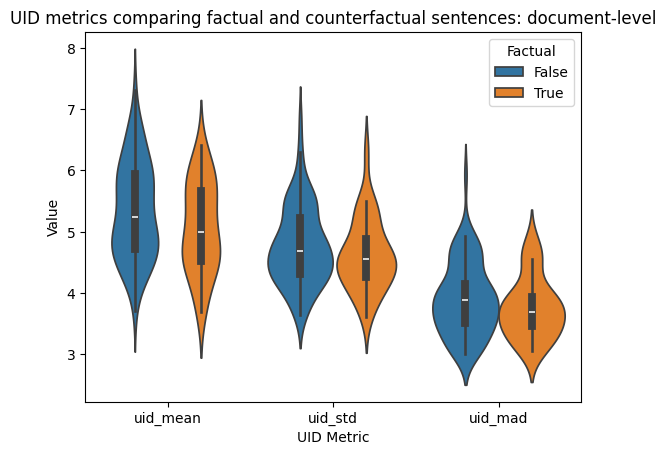

In [65]:
fig, ax = plt.subplots()
sns.violinplot(data=passive_cf_comparison.melt(
       id_vars=['factual'],
       value_vars=['uid_mean', 'uid_std', 'uid_mad'],
       var_name='UID Metric',
       value_name='Value'
       ), 
        hue='factual', y='Value', x='UID Metric', ax=ax)
plt.title(f"UID metrics comparing factual and counterfactual sentences: {context_lvl}-level")
handles, labels = ax.get_legend_handles_labels()
plt.legend(title="Factual")

<Axes: ylabel='uid_mean'>

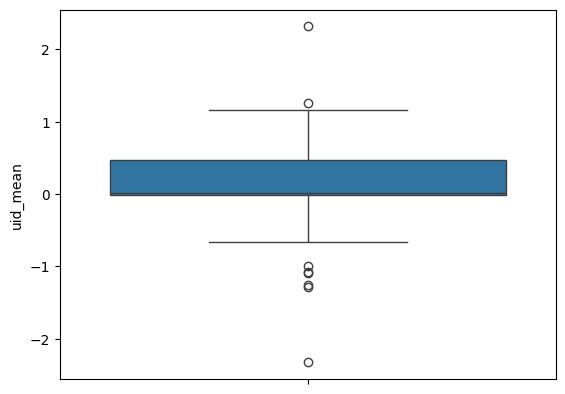

In [66]:
deltas = passive_cf_comparison.groupby(['doc_name', 'sent_idx'])[['uid_mean', 'factual']].apply(lambda g: g.diff()).reset_index()
sns.boxplot(deltas[deltas['uid_mean'].notna()]['uid_mean'])

In [67]:
deltas['uid_mean'].mean()

np.float64(0.10269925744565594)